<a href="https://colab.research.google.com/github/Hiji1023/mini_project/blob/main/%ED%99%94%EC%A7%88_%EA%B0%9C%EC%84%A0_%EC%86%90%EC%83%81%EB%90%9C_%EC%9D%98%EB%A5%98_%EC%9D%B4%EB%AF%B8%EC%A7%80_%ED%99%94%EC%A7%88_%EB%B3%B5%EA%B5%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# 주제 : 화질 개선 - 손상된 의류 이미지 화질 복구하기
--------------
## 실습 가이드
    1. 데이터를 다운로드하여 Colab에 불러옵니다.
    2. 필요한 라이브러리는 모두 코드로 작성되어 있습니다.
    3. 코드는 위에서부터 아래로 순서대로 실행합니다.
    4. 전체 문제 구성은 좌측 첫 번째 아이콘을 통해 확인할 수 있습니다.

## 데이터 소개
     - 이번 주제의 데이터는 너무나 유명한 fashion MNIST 데이터를 사용합니다.
  ![fashion mnist 이미지](https://rviews.rstudio.com/post/2019-10-31-a-comparison-of-methods-for-predicting-clothing-classes-using-the-fashion-mnist-dataset-in-rstudio-and-python-part-1/index_files/figure-html/unnamed-chunk-8-1.png)

      위의 이미지는 다음과 같은 것을 보여줍니다.  
      (a) 28x28의 배열에서 의류들이 어떻게 모사되는지   
      (b) 각 셔츠, 바지, 풀오버, 드레스 등 다양한 의류 그림의 모습들


- 데이터 출처: [fashionmnist](https://www.kaggle.com/zalando-research/fashionmnist)

## 최종 목표

    - noisy가 있는 fashion MNIST 이미지 원래대로 복원하기
    - 흑백 이미지와 칼라 이미지의 차이
    - 이미지에 Noisy를 추가하는 방법
    - 이미지에 대한 오토인코더식 접근 방법

- 출제자 : 손근영 강사
---


In [77]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from IPython.display import Image

warnings.filterwarnings('ignore')
%matplotlib inline

SEED = 34

## Step 1. 도입전 기본 처리

### 문제 1. fashion mnist 데이터 살펴보기

In [78]:
# 데이터를 불러오는 코드를 작성해주세요.
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

### 문제 2. train_images/labels와 test_images/labes의 shape을 출력해보세요.

In [79]:
# 데이터의 크기를 shape 함수를 통해 출력해주세요.
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


### 문제 3. (28, 28) 형태의 이미지를 plt을 이용하여 출력해보세요.

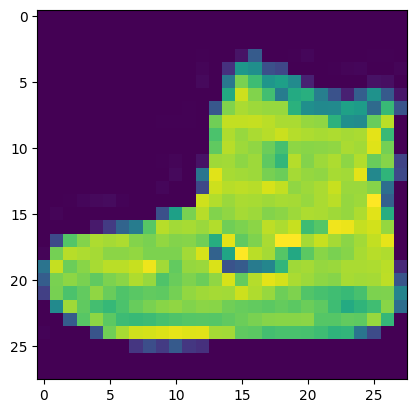

In [80]:
# 28x28의 흑백 이미지를 plt를 이용하여 출력하는 코드를 작성해보세요
plt.imshow(train_images[0])
plt.show()

### 문제 4. train_images에서 0이 아닌 값들을 출력해보세요.

In [81]:
# 하나의 이미지에 대한 모든 0이 아닌 값을 출력하는 코드를 작성하세요
list(filter(lambda x:x != 0,train_images[0].reshape(-1)))[0:10]

[1, 13, 73, 1, 4, 1, 1, 3, 36, 136]

### 문제 5. train_images의 dtype을 출력해보세요.

In [82]:
# dtype을 이용하여 이미지의 np array type을 확인해보세요.
#0 T-shirt/top
#1 Trouser/pants
#2 Pullover shirt
#3 Dress
#4 Coat
#5 Sandal
#6 Shirt
#7 Sneaker
#8 Bag
#9 Ankle boot
train_images.dtype

dtype('uint8')

## Step 2. 전처리

### 문제 6. train/test 이미지 데이터의 범위 확인

In [83]:
# test_images의 shape과 dtype, 0이 아닌 숫자를 출력하는 코드를 작성하세요.
print(test_images.shape, test_images.dtype)
print(list(filter(lambda x : x != 0, test_images[0].reshape(-1)))[:10])

(10000, 28, 28) uint8
[3, 1, 7, 37, 1, 2, 27, 84, 11, 119]


### 문제 7. train/test 이미지 데이터의 최소/최대값을 출력

In [84]:
# train/test 전체 데이터에서 각 images, labels의 min, max를 출력하는 코드를 작성하세요.
print(min(train_images.reshape(-1)), max(train_images.reshape(-1)))
print(min(test_images.reshape(-1)), max(test_images.reshape(-1)))

0 255
0 255


### 문제 8. 정수형을 실수형으로 변경 후 dtype으로 비교

In [85]:
# train/test 데이터의 타입을 dtype으로 확인해보고 실수형으로 전환하는 코드를 작성하세요.
print(train_images.dtype)
train_images = train_images.astype(np.float64)
test_images = test_images.astype(np.float64)
print(train_images.dtype, test_images.dtype)

uint8
float64 float64


### 문제 9. 데이터 0-1 노말라이즈 수행


#### 힌트

일반적으로 0-1사의의 값을 가지게 하기 위해서는 다음 수식을 사용합니다.

$$normalize(x) = \frac{x - 최소값}{최대값 - 최소값}$$

이 경우 최소값이 0이기 떄문에 다음과 같이 간편하게 구할 수 있습니다.

$$normalize(x) = \frac{x}{최대값}$$

In [86]:
# images의 값이 0-1사이의 값을 같도록 코드를 작성해보세요.
train_images = train_images / max(train_images.reshape(-1))
test_images = test_images / max(test_images.reshape(-1))


### 문제 10. 0-1 노말라이즈 후 데이터의 값이 변경되었는지 문제 6, 7의 방법을 이용하여 확인하세요.

In [87]:
# 노말라이즈 후 min/max, shape, 0이 아닌 값, dtype 등을 확인하는 코드를 작성해보세요.
print(max(test_images.reshape(-1)),min(test_images.reshape(-1)))
print(max(train_images.reshape(-1)),min(test_images.reshape(-1)))
print(train_images.shape, test_images.shape)

1.0 0.0
1.0 0.0
(60000, 28, 28) (10000, 28, 28)


### 문제 11. 흑백 이미지를 칼라 이미지의 shape으로 변경하세요.

In [88]:
# (배치, 28, 28)의 흑백 shape을 (배치, 28, 28, 3)의 칼라 shape의 영역으로 확대하는 코드를 추가하세요.
from skimage import color

train_images = np.array([color.gray2rgb(img) for img in train_images])
test_images = np.array([color.gray2rgb(img) for img in test_images])

print(train_images.shape, test_images.shape)

(60000, 28, 28, 3) (10000, 28, 28, 3)


## Step 3. 시각화 방법

### 문제 12. train_image의 이미지를 5장 획득하여 (5, 28, 28, 3)의 shape을 출력하세요.

In [89]:
# (60000, 28, 28, 3)인 train_images에서 (5, 28, 28, 3)을 획득하는 코드를 작성하세요.
print(train_images[:5].shape)

(5, 28, 28, 3)


### 문제 13. 획득한 5장의 이미지를 (28, 28 * 5, 3)의 shape으로 변경해보세요.

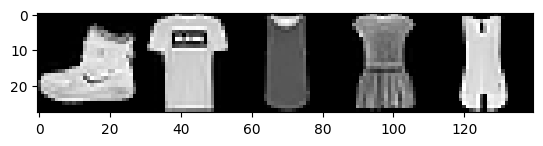

In [90]:
# np.hstack은 height 방향의 배열을 풀어서 width 방향으로 연결해줍니다.
# 해당 기능을 쓰면 (height, image_height, image_width, color)의 shape을 (image_height, image_width * height, color)으로 바꿔 줄 수 있습니다.
# 코드를 작성해보세요. (정답)
plt.imshow(np.hstack(train_images[:5]))
plt.show()

### 문제 14. np.hstack은 tensorflow에서 제공하는 방법이 아니므로 transpose 함수를 이용하여 (28, 28 * 5, 3)로 shape을 변경해보세요.

In [91]:
# transpose는 tensor의 axis를 섞는 기능을 합니다.
# 해당 기능을 이용해서 (28, 140)을 작성하는 코드를 작성해보세요.
train_images[:5].transpose((1,0,2,3)).reshape(28,-1,3).shape

(28, 140, 3)

### 문제 15. (28, 140, 3)이 된 tensor를 plt로 출력해보세요.

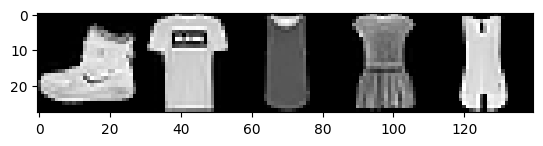

In [92]:
# (28, 140, 3)의 이미지를 plt로 출력해보세요.
plt.imshow(train_images[:5].transpose((1,0,2,3)).reshape(28,-1,3))
plt.show()

## Step 4. Data augmentation - Noise 추가 방법

### 문제 16. np.random.random 함수를 이용하여 0-1 사이의 랜덤값을 3회 print로 출력해보시오.

In [93]:
# np.random.ranodm을 이용해서 0-1 사의의 랜덤값을 3회 출력하는 코드를 작성하시오.
print(np.random.random())
print(np.random.random())
print(np.random.random())

0.4732737384701313
0.4536594497643439
0.48173182403308923


### 문제 17. np.random.random 함수와 shape 파라매터를 (28, 28, 3)의 칼라 랜덤 노이즈를 생성해보세요.

In [94]:
# np.random.random 함수와 shape 파라매터를 이용하여 (28, 28, 3)의 랜덤 노이즈를 생성하는 코드를 작성하시오.
np.random.random((28,28,3)).shape

(28, 28, 3)

### 문제 18. 생성된 random (28, 28, 3) 노이즈를 plt를 통하여 확인해보세요.

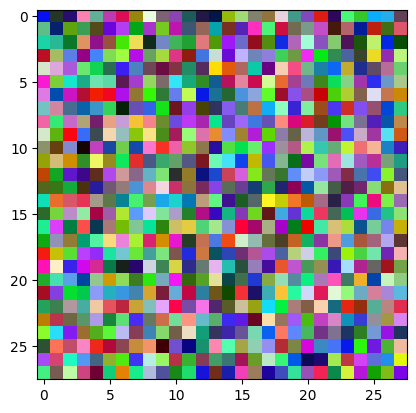

In [95]:
# plt를 통하여 random (28, 28, 3) 노이즈를 2회 출력하는 코드를 작성하시고, 이미지가 다른지 확인하세요.
plt.imshow(np.random.random((28,28,3)))
plt.show()

### 문제 19. 가우시안 노이즈 함수를 사용하여 평균 0, 표준편차 0.1, 사이즈 1로 랜덤 값을 3번 출력하세요. (np.random.normal)

In [96]:
# 가우시안 노이즈 함수를 이용하여 mu 0.1 std 0.1 size 1인 랜덤값을 3번 출력하는 코드를 작성하세요.
print(np.random.normal(0.1, 0.1,1))
print(np.random.normal(0.1, 0.1,1))
print(np.random.normal(0.1, 0.1,1))

[0.15227596]
[0.12771939]
[0.0373308]


### 문제 20. 가우시안 노이즈 함수의 옵션을 문제 17과 동일하지만 평균이 3.0인 경우, 표준 편차가 0.01인 경우로 각각 3회씩 출력해보세요.

In [97]:
# 가우시안 노이즈 함수 mu = 3.0, std = 0.1, size = 1을 3 회 출력, mu = 0.0, std = 0.01, size = 1을 3회 출력하는 코드를 작성해보세요.
print(np.random.normal(3.0,0.01,1))
print(np.random.normal(3.0,0.01,1))
print(np.random.normal(3.0,0.01,1))

[2.99066074]
[3.00000328]
[2.99727749]


### 문제 21. 가우시안 노이즈 함수를 size를 (28, 28, 3)로 생성 후 plt로 출력해보세요. 범위는 0-1의 사이로 고정해야합니다.

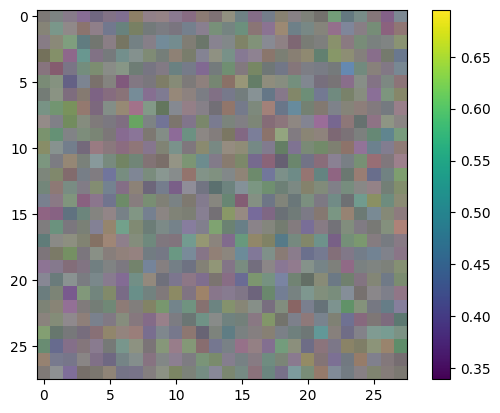

In [98]:
# 가우시안 노이즈 함수를 문제 17의 옵션으로 size를 (28, 28, 3)로 생성 후 plt로 출력하는 코드를 작성해보세요.
noisy = np.random.normal(0.5 ,0.05,(28,28,3))
noisy[noisy > 1.0] = 1.0
plt.imshow(noisy)
plt.colorbar()
plt.show()

### 문제 22. train_images의 5번째 이미지와 가우시안 노이즈 (28, 28, 3)를 생성 한 뒤 각각 tensor를 더한 뒤 noisy_image 변수에 할당 해보세요.

In [99]:
# train_images[5]와 가우시안 노이즈 (28, 28, 3)을 더한 뒤 noisy_image 변수에 할당하는 코드를 작성하세요. mu = 0.5, std = 0.05
noisy_image = train_images[5] + noisy
noisy_image[noisy_image>1] = 1.0

### 문제 23. noisy_image를 plt를 통해서 출력해보세요.

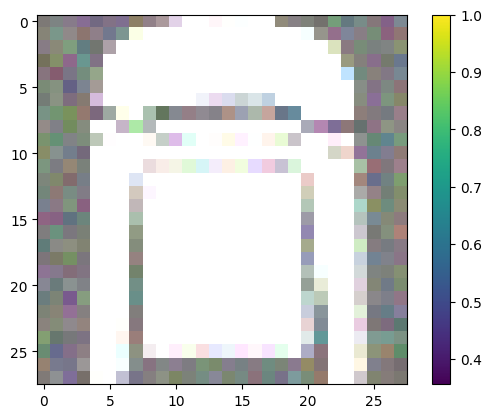

In [100]:
# noisy_image를 plt로 출력하는 코드를 작성해보세요.
plt.imshow(noisy_image)
plt.colorbar()
plt.show()

### 문제 24. 위의 방법을 전부 활용하여 train_images와 test_images 데이터에 랜덤 노이즈를 추가한 train_noisy_images와 test_noisy_images를 생성해보세요.

In [101]:
# train_noisy_image와 test_nosiy_images를 생성하는 코드를 작성하세요.
train_noisy_images = train_images + np.random.normal(0.5, 0.05,train_images.shape)
train_noisy_images[train_noisy_images>1.0] = 1.0
test_noisy_images = test_images + np.random.normal(0.5, 0.05,test_images.shape)
test_noisy_images[test_noisy_images>1.0] = 1.0

### 문제 25. 노이즈가 추가된 train_noisy_images에서 5장을 plt으로 출력해보세요.

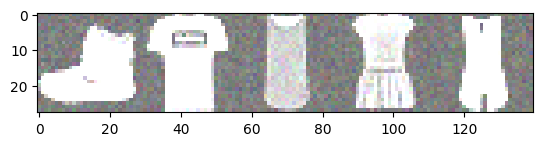

In [102]:
# 노이즈가 추가된 train_noisy_images에서 5장을 plt으로 출력하는 코드를 작성하세요.
plt.imshow(train_noisy_images[:5].transpose((1,0,2,3)).reshape((28,-1,3)))
plt.show()

## Step 5. 모델링

### 문제 26. 해당 학습셋을 처리하는 이미지 디노이징 모델을 작성하세요.

In [103]:
# input (28, 28, 3), output (28, 28, 3)을 처리할 수 있는 모래시계 모양의 모델을 작성하세요.
# auto encoder형태로 만듬
from keras.layers import Dense, Input, Conv2D, Conv2DTranspose, Flatten, Reshape
from keras.models import Model

inputs = Input(shape=(28,28,3))
x = Conv2D(32, 3, 2, activation='relu', padding ='same')(inputs)
x = Conv2D(64, 3, 2, activation='relu', padding ='same')(x)
x = Flatten()(x)
latent = Dense(10)(x)

x = Dense(7*7*64)(latent)
x = Reshape((7,7,64))(x)
x = Conv2DTranspose(64,3,2,activation='relu', padding='same')(x)
x = Conv2DTranspose(32,3,2,activation='relu', padding='same')(x)
x = Conv2DTranspose(3,3,activation='sigmoid', padding='same')(x)
model = Model(inputs, x)

### 문제 27. 모델 요약 정보를 출력해보세요.

In [104]:
# 모델 요약 정보를 출력해보세요.
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 28, 28, 3)]       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 14, 14, 32)        896       
                                                                 
 conv2d_11 (Conv2D)          (None, 7, 7, 64)          18496     
                                                                 
 flatten_5 (Flatten)         (None, 3136)              0         
                                                                 
 dense_10 (Dense)            (None, 10)                31370     
                                                                 
 dense_11 (Dense)            (None, 3136)              34496     
                                                                 
 reshape_5 (Reshape)         (None, 7, 7, 64)          0   

### 문제 28. 만든 모델에 로스와 옵티마이저, 메트릭을 설정하세요.

In [105]:
# 만든 모델에 loss는 mse, optimizer는 adam 매트릭은 accuracy으로 설정하는 코드를 작성하세요.
model.compile(loss = 'mse', optimizer='adam', metrics=['accuracy'])

### 문제 29. 만든 모델에 train_noisy_images를 학습시켜 보세요.

In [106]:
from tensorflow.python.platform.tf_logging import TaskLevelStatusMessage
# train_noisy_images를 학습시키고 5 epochs을 돌리고 그 진행 사항을 hist에 저장하는 코드를 작성하세요
hist = model.fit(train_noisy_images, train_images, validation_data = (test_noisy_images, test_images), epochs =5, verbose = 1)

Epoch 1/5
1875/1875 [==============================] - 126s 67ms/step - loss: 0.0290 - accuracy: 0.4164 - val_loss: 0.0189 - val_accuracy: 0.4256
Epoch 2/5
1875/1875 [==============================] - 121s 64ms/step - loss: 0.0182 - accuracy: 0.4145 - val_loss: 0.0175 - val_accuracy: 0.4023
Epoch 3/5
1875/1875 [==============================] - 121s 65ms/step - loss: 0.0168 - accuracy: 0.3742 - val_loss: 0.0162 - val_accuracy: 0.3723
Epoch 4/5
1875/1875 [==============================] - 120s 64ms/step - loss: 0.0159 - accuracy: 0.3629 - val_loss: 0.0157 - val_accuracy: 0.3632
Epoch 5/5
1875/1875 [==============================] - 121s 65ms/step - loss: 0.0154 - accuracy: 0.3511 - val_loss: 0.0149 - val_accuracy: 0.3447


### 문제 30. 학습 진행 사항을 plt으로 출력하세요.

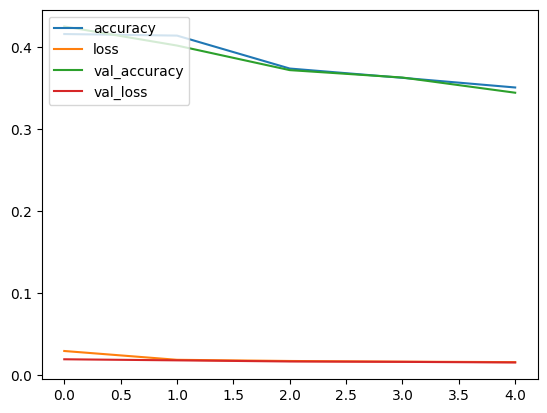

In [115]:
# hist의 accuracy plt의 plot을 이용하여 출력하는 코드를 작성하세요
plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_accuracy'], label='val_accuracy')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.legend(loc='upper left')
plt.show()

## Step 6. 결과 확인

### 문제 31. 완성된 모델에서 test_noisy_image를 1장 넣고 결과를 res 변수에 저정하세요.

In [118]:
# 모델에 test_noisy_images 중 1장을 넣고 결과를 받는 코드를 작성하세요.
res = model.predict(test_noisy_images[7:8])
res.shape

1/1 [==============================] - 0s 50ms/step


(1, 28, 28, 3)

### 문제 32. res와 test_noisy_images[0], test_images[0]를 width 방향으로 결합하여 plt로 출력하세요.

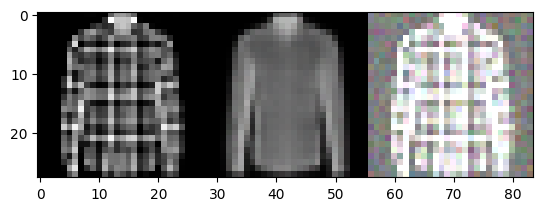

In [120]:
# res와 test_noisy_images[0], test_images[0]를 width 방향으로 결합하여 (28, 28 * 3, 3) 의 이미지를 만들어 plt로 출력하는 코드를 작성하세요.
plt.imshow(np.concatenate([test_images[7], res[0], test_noisy_images[7]], axis =1))
plt.show()

# res의 이미지는 모델이 예측한 이미지로 체크무늬가 지워짐 -> epoch를 더 늘려 학습을 더 시켜봐야함

### 문제 33. 5장의 test_noisy_images를 모델에 넣은 뒤 결과를 31번의 방식으로 비교하세요.

1/1 [==============================] - 0s 45ms/step


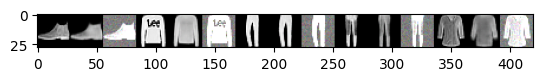

In [124]:
# 5장의 이미지를 모델에 넣고 결과를 31번과 같은 방식으로 비교하는 코드를 작성하세요
five = model.predict(test_noisy_images[:5])
# 2D image로 만듬
result = np.concatenate([test_images[:5], five, test_noisy_images[:5]], axis = 2).transpose((1,0,2,3)).reshape((28,-1,3))
plt.imshow(result)
plt.show()

## Step 7. 모델 저장 및 로드, 다운

### 문제 34. 모델을 저장하세요.

In [125]:
# 모델을 저장하는 코드를 작성하세요.
model.save("./lecture002.h5")

### 문제 35. 모델 파일을 새로운 모델에 로드하세요.

In [126]:
# 모델을 로드하는 코드를 작성하세요.
new_model = tf.keras.models.load_model('./lecture002.h5')

### 문제 36. 로드한 모델을 test 데이터로 평가해보세요.


In [130]:
# 로드한 모델을 test 데이터로 평가해보세요.
loss, accuracy = model.evaluate(test_noisy_images, test_images, verbose =1)
loss, accuracy = new_model.evaluate(test_noisy_images, test_images, verbose =1)
print(loss, accuracy)

313/313 [==============================] - 8s 23ms/step - loss: 0.0149 - accuracy: 0.3447
0.014942564070224762 0.34465816617012024


### 문제 37. 모델을 내 컴퓨터에 저장해보세요

In [114]:
# 모델을 내 컴퓨터에 저장해보세요.

In [131]:
from google.colab import files
files.download('./lecture002.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>